# Face Recognition Project

*Arandi Mallawa, Jade Phoreman, Sohyun Yoo, Rodney Johnston, Aurora Travers, Chan Choon Yong*

Our goal is to create a face recognition system that will be able to classify the emotions of humans. This project involves training a neural network to distinguish between emotions (anger, sadness, neutral, happiness, disgust, fear, surprise) communicated by facial expressions. 

We will start by creating a script that will recognize a face (most likely using cv2 package) and mark the face with a distinct box over their face on the live feed. After this process, we will build a neural network (using the tensor and keras packages), so that we can identify facial emotions, particularly using the training data. We will most likely partition the project so that we can work individually on a particular part and then meet up to put together all of the code and debug the system.

The dataset that will be used is labeled and there is a provided testing and training ground, both sets of data contains files with anger, sadness, neutral, happiness, disgust, fear, surprise.





# 1. Import Face Recognition Dataset
Credits: [Kaggle](https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset)

In [147]:
# Download dataset
!wget https://raw.githubusercontent.com/Jade-P/MLGroupProject/Sad--Brian/archive.zip

--2022-11-20 02:45:50--  https://raw.githubusercontent.com/Jade-P/MLGroupProject/Sad--Brian/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62587032 (60M) [application/zip]
Saving to: ‘archive.zip.1’

archive.zip.1       100%[===================>]  59.69M   144MB/s    in 0.4s    

2022-11-20 02:45:53 (144 MB/s) - ‘archive.zip.1’ saved [62587032/62587032]



In [148]:
# Unzip Dataset (Takes 1 Minute)
!unzip archive.zip

Archive:  archive.zip
replace Testing/Testing/Angry/Angry-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 2. Import Libraries and Constants

In [160]:
# Libraries

import cv2
import numpy as np
import os 
from tqdm import tqdm # For Loop's Progress Bar
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping


import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123


In [161]:
from keras.optimizers import Adam, RMSprop
# Constants
TRAIN_DIR = ('Training/Training/')
TEST_DIR = ('Testing/Testing/')

##**Loading Data** 

In [162]:
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']
IMG_SIZE= (48, 48) # Standardise image resolution

In [163]:
def load_data(dir_path, IMG_SIZE):
    """
    Given directory path to dataset, initialise the images in the directory to
    the image data (X) and the corresponding emotion (y).
    
    Parameters:
    1. dir_path: Directory path to dataset
    2. IMG_SIZE: Image resolution to standardise

    Returns:
    1. X: Image data 
    2. y: Emotions corresponding to the image

    """

    X = [] #image_data (explanatory variable)
    y = [] #emotion (dependent variable)

    for emotion in emotions:
      file_list = os.listdir(dir_path + emotion)
      for file in file_list:
        img_path = (dir_path + emotion + '/' + file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype('float32') / 255 # Normalising image colour data
        img_resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
        X.append(img_resized)
        y.append(emotion)
      print(f"Images loaded from {dir_path+emotion} directory.")

    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y

In [171]:
X_train, y_train = load_data(TRAIN_DIR, IMG_SIZE)

Images loaded from Training/Training/Angry directory.
Images loaded from Training/Training/Fear directory.
Images loaded from Training/Training/Happy directory.
Images loaded from Training/Training/Neutral directory.
Images loaded from Training/Training/Sad directory.
Images loaded from Training/Training/Suprise directory.
28273 images loaded from Training/Training/ directory.


In [172]:
X_test, y_test = load_data(TEST_DIR,IMG_SIZE)

Images loaded from Testing/Testing/Angry directory.
Images loaded from Testing/Testing/Fear directory.
Images loaded from Testing/Testing/Happy directory.
Images loaded from Testing/Testing/Neutral directory.
Images loaded from Testing/Testing/Sad directory.
Images loaded from Testing/Testing/Suprise directory.
7067 images loaded from Testing/Testing/ directory.


##**Data Visualisation**

In [170]:
def plot_samples(X, y, num_images):
    """
    View a subset of images loaded

    Parameters:
    1. X: Image data
    2. y: Emotions corresponding to the image
    3. num_images: Number of images to view per emotion

    """
    for emotion in emotions:
        imgs = X[np.argwhere(y == emotion)][:num_images]
        num_cols = 10
        num_rows = int(num_images/num_cols)

        plt.figure(figsize=(10,3))
        index = 1
        for img in imgs:
            plt.subplot(num_rows,num_cols,index)
            plt.imshow(img[0], cmap='gray')

            plt.xticks([])
            plt.yticks([])
            index += 1
        plt.suptitle(emotion)
        plt.show()

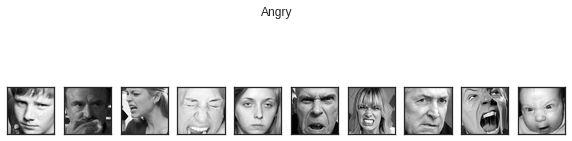

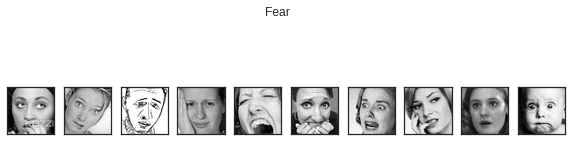

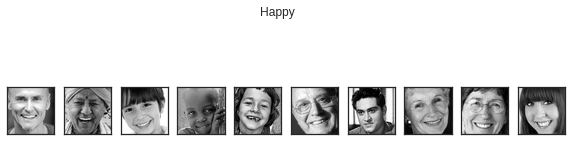

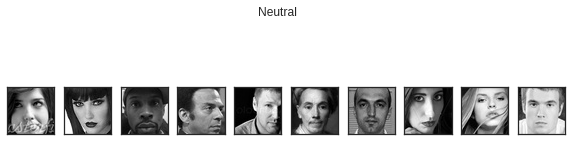

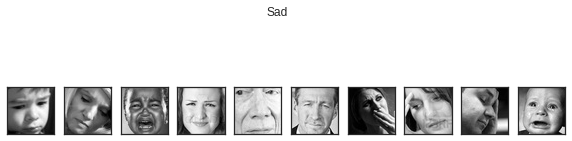

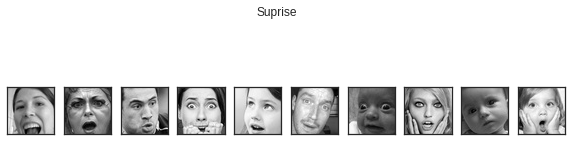

In [173]:
plot_samples(X_train, y_train, 10)

##**Counting data for each class**

In [182]:
import pandas as pd

_, train_count = np.unique(y_train,return_counts=True)
_, test_count = np.unique(y_test,return_counts=True)

df = pd.DataFrame(data = (train_count, test_count))
df = df.T
df = df.rename(columns={0: "train", 1: "test"})
df['emotion'] = emotions
df

,train,test,emotion
0,3995,958,Angry
1,4097,1024,Fear
2,7215,1774,Happy
3,4965,1233,Neutral
4,4830,1247,Sad
5,3171,831,Suprise


Pie chart representation

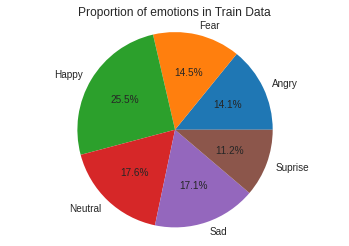

In [183]:
plt.pie(train_count,
       explode=(0,0,0,0,0,0),
       labels=emotions,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of emotions in Train Data")
plt.show()

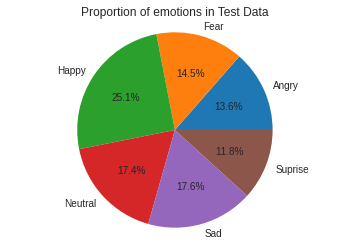

In [184]:
plt.pie(test_count,
       explode=(0,0,0,0,0,0),
       labels=emotions,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of emotions in Test Data")
plt.show()

Bar chart representation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



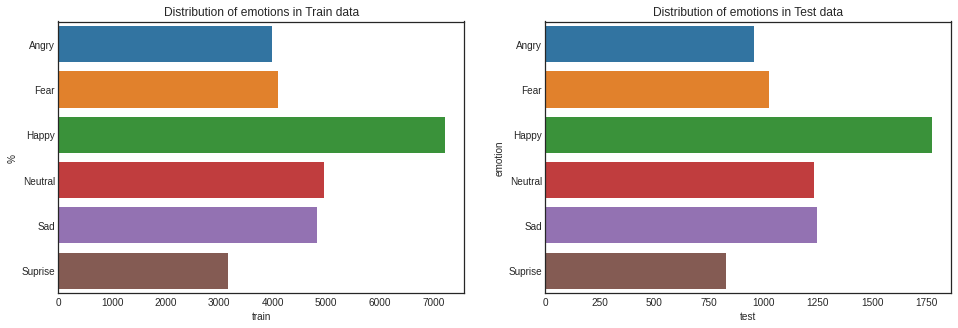

In [186]:
import seaborn as sns

plt.style.use('seaborn-white')
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(df["train"], df["emotion"], ax=ax[0])
ax[0].set_title("Distribution of emotions in Train data"), ax[0].set_ylabel("%")
sns.barplot(df["test"], df["emotion"], ax=ax[1])
ax[1].set_title("Distribution of emotions in Test data"), ax[0].set_ylabel("%")
plt.show()

In [191]:
Happy_count = df[df['emotion'] == 'Happy']['test']

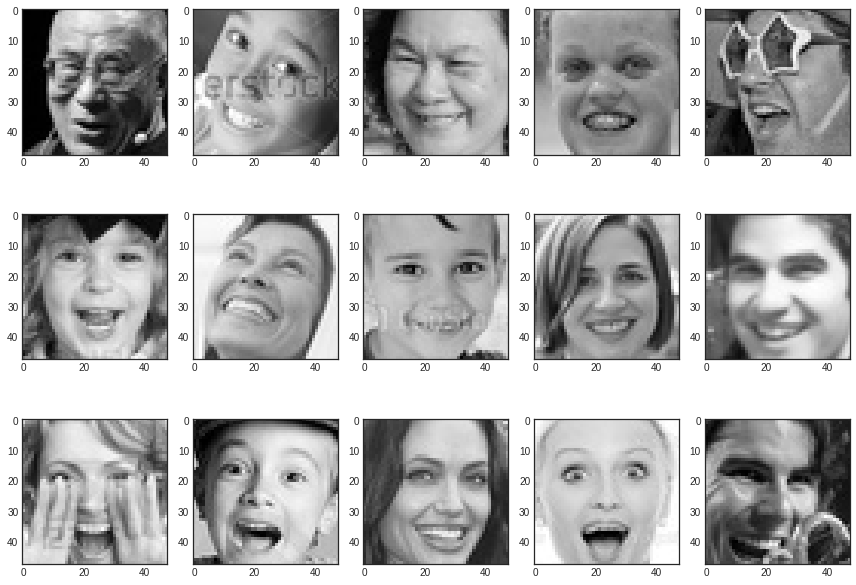

In [192]:
pic_size = 48

plt.figure(0, figsize=(12,20))
cpt = 0
np.random.seed(42)

random_img = np.random.randint(0, Happy_count, size=15)

for i in random_img:
    cpt += 1
    plt.subplot(7,5,cpt)
    img = cv2.imread('Training/Training/'+'Happy'+"/"+os.listdir("Training/Training/"+'Happy')[i])
    img = img.astype('float32') / 255
    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
    plt.imshow(resized,cmap="gray")
    pass

plt.tight_layout()
plt.show()

In [193]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  

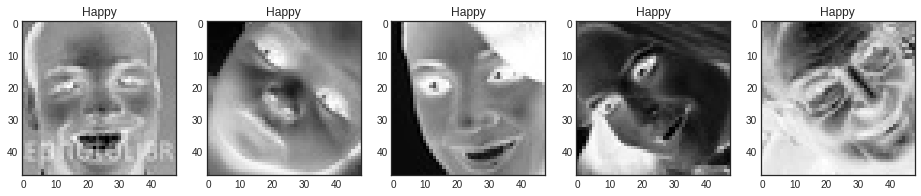

In [194]:
Happy_DIR = TRAIN_DIR + "/Happy/"
Happy_imgs = [Happy_DIR + path for path in os.listdir(Happy_DIR)]

fig, axes = plt.subplots(1,5, figsize=(16,16))
for ax in axes.reshape(-1):
    img_path = np.random.choice(Happy_imgs)
    img = Image.open(img_path)
    img.thumbnail((300,300))
    ax.imshow(img), ax.set_title("Happy")
plt.show()

##**Finding duplicates**

In [195]:
image_list = []

path = TRAIN_DIR + '/Happy'

for f in os.listdir(path):
  image_list.append(f)

img_size = list(map(lambda x: os.path.getsize(path + '/' + x), image_list))

# Find Same Photos
img_data = pd.DataFrame({'filename':image_list, 'size':img_size})

print('number of images :', len(img_data))

number of images : 7215


In [196]:
img_data

,filename,size
0,Happy-708.jpg,1473
1,Happy-4802.jpg,1827
2,Happy-2400.jpg,1576
3,Happy-3472.jpg,1549
4,Happy-1267.jpg,1933
...,...,...
7210,Happy-2812.jpg,1474
7211,Happy-286.jpg,1668
7212,Happy-6441.jpg,1645
7213,Happy-1094.jpg,1724


In [197]:
# Photo Value Counts
filename_cnts = pd.DataFrame({'filename':img_data['filename'].value_counts().index, 'fn_counts':img_data['filename'].value_counts().values})   
imgsize_cnts = pd.DataFrame({'size':img_data['size'].value_counts().index, 'size_counts':img_data['size'].value_counts().values})   

img_data = pd.merge(img_data, filename_cnts, how = 'left', on = 'filename')
img_data = pd.merge(img_data, imgsize_cnts, how = 'left', on = 'size')

img_data.sample(2)

,filename,size,fn_counts,size_counts
5272,Happy-4173.jpg,1471,1,12
3114,Happy-4537.jpg,1465,1,13


In [198]:
SimilarSizeData = imgsize_cnts[imgsize_cnts['size_counts'] > 1]

In [199]:
def CompareImage(imageA, imageB):

    # Grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Check Image structure
    if len(grayA)==len(grayB):
        (score, diff) = structural_similarity(grayA, grayB, full=True)

    return score

In [200]:
import cv2  
from skimage.metrics import structural_similarity

delete = []
similar = []

for i in range(len(SimilarSizeData)):

    temp = img_data[img_data['size']==SimilarSizeData['size'][i]].reset_index(drop = True).sort_values(['filename'])

    candidates = []

    for j in range(len(temp) - 1):
      for k in range(j+1, len(temp)):
        filenameA = temp['filename'][j]
        filenameB = temp['filename'][k]
        
        imageA = cv2.imread(path+'/'+filenameA)
        imageB = cv2.imread(path+'/'+filenameB)

        score = CompareImage(imageA, imageB)
        if (score == 1):
          delete.append([filenameA, filenameB])
        elif (score > 0.5):
          similar.append([filenameA, filenameB])
          print("score: " + str(score))

score: 0.507220860919935
score: 0.507220860919935
score: 0.5461958331723261
score: 0.5316829843490676
score: 0.5190429726335152
score: 0.5356492046874829
score: 0.7168389603349193


In [201]:
print(str(len(delete)) + " same image pairs found")
print(str(len(similar)) + " similar image pairs found")

134 same image pairs found
7 similar image pairs found


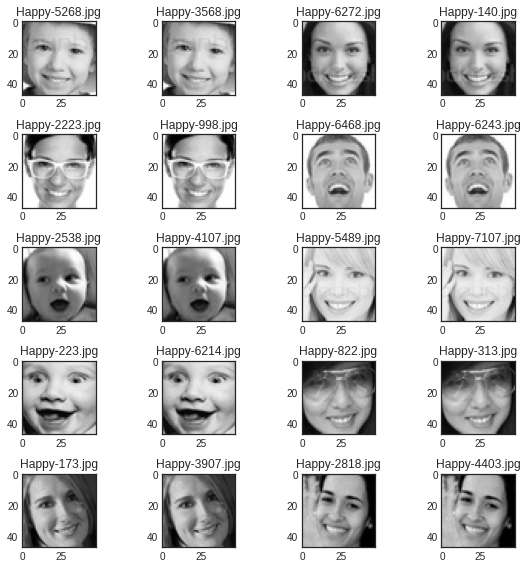

In [202]:
pic_size = 48

plt.figure(0, figsize=(8,8))
cpt = 0

for i in range(len(delete[:10])):
  for filename in delete[i]:
    cpt += 1
    ax = plt.subplot(5,4,cpt)
    ax.set_title(filename)

    img = cv2.imread(path+"/"+ filename)
    plt.imshow(img,cmap="gray")
    pass

plt.tight_layout()
plt.show()

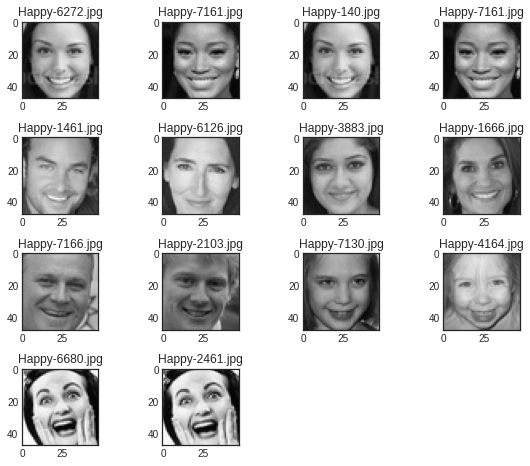

In [203]:
pic_size = 48

plt.figure(0, figsize=(8,8))
cpt = 0

for i in range(len(similar)):
  for filename in similar[i]:
    cpt += 1
    ax = plt.subplot(5,4,cpt)
    ax.set_title(filename)

    img = cv2.imread(path+"/"+ filename)
    plt.imshow(img,cmap="gray")
    pass

plt.tight_layout()
plt.show()

##**Sizes distribution**

In [204]:
path = 'Training/Training/Happy'

In [205]:
widths = dict()
heights = dict()

for img in os.listdir(path):
  img = cv2.imread(path + '/' + img)
  width, height, _ = img.shape
  widths[width] = widths.get(width,0)+1
  heights[height] = widths.get(height,0)+1

In [206]:
print(widths)
print(heights)

{48: 7215}
{48: 7216}


##**Model Building**

We plan to use CNN to analyse our image data. 

While we could build our CNN from scratch, there are many CNN model architectures that are openly available. Some of these model architectures have been tested to be highly accurate and reliable. 

Some examples are:
1. VGG16
2. ??
3. ??

We will build our models under these model architectures, and test which model gives us the best performance. 



In [ ]:
# One-hot encoding
y_train = pd.get_dummies(y_train)
print(y_train.shape)
y_test = pd.get_dummies(y_test)
print(y_test.shape)

In [ ]:
base_model = VGG16(
    weights=None, 
    include_top=False, 
    input_shape=IMG_SIZE+(1,)
    )

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
X_train = preprocess_input(X_train) 
X_test = preprocess_input(X_test)

Now we add the last layers for our specific problem. This is based on trial and error.

In [ ]:
num_emotions = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(6, activation="softmax"))

In [ ]:
def gen_model(model, X_train, Y_train, epochs, batch_size):
   
    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

    es = EarlyStopping(monitor='accuracy', mode='max', patience=3,  restore_best_weights=True)
    
    history = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , verbose=1
                       , callbacks=[es])
    return history


In [ ]:
epochs = 40
batch_size = 64

history = gen_model(model, X_train, y_train, epochs, batch_size)

Epoch 1/40
442/442 [==============================] - 31s 65ms/step - loss: 0.4626 - accuracy: 0.2407
Epoch 2/40
442/442 [==============================] - 28s 64ms/step - loss: 0.4492 - accuracy: 0.2533
Epoch 3/40
442/442 [==============================] - 29s 65ms/step - loss: 0.4401 - accuracy: 0.2687
Epoch 4/40
442/442 [==============================] - 29s 65ms/step - loss: 0.4008 - accuracy: 0.3601
Epoch 5/40
442/442 [==============================] - 29s 65ms/step - loss: 0.3751 - accuracy: 0.4151
Epoch 6/40
442/442 [==============================] - 29s 65ms/step - loss: 0.3546 - accuracy: 0.4574
Epoch 7/40
442/442 [==============================] - 29s 65ms/step - loss: 0.3362 - accuracy: 0.4959
Epoch 8/40
442/442 [==============================] - 29s 65ms/step - loss: 0.3179 - accuracy: 0.5335
Epoch 9/40
442/442 [==============================] - 29s 65ms/step - loss: 0.2992 - accuracy: 0.5686
Epoch 10/40
442/442 [==============================] - 29s 65ms/step - loss: 0.278

#**Predict Emotions**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7067 images belonging to 6 classes.


In [ ]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [emotions[k] for k in y_pred]

221/221 [==============================] - 3s 12ms/step


In [ ]:
filenames = pred_generator.filenames
actual_class = [emotions[h] for h in pred_generator.classes]

In [ ]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

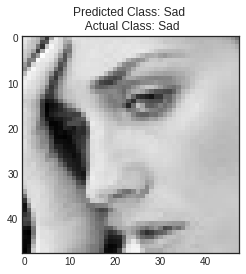

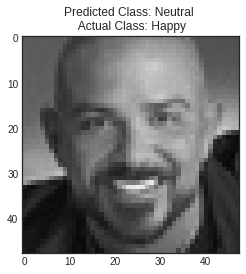

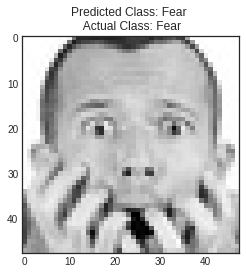

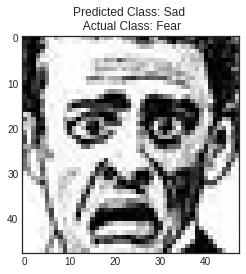

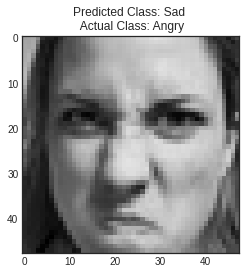

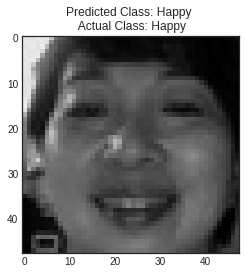

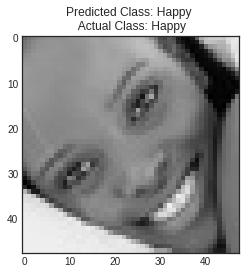

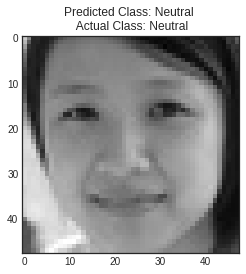

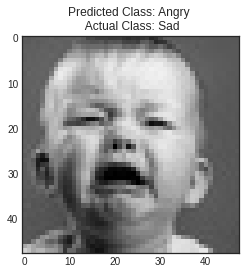

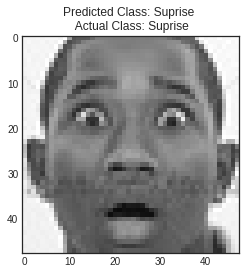

In [ ]:
from random import randint

l = len(filenames)
base_path = TEST_DIR
for i in range(10):  # 10 images
    
    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]
    
    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass